# Content

+ Discriminant analysis
+ Method of head components
+ Classification

In [2]:
import scipy.stats as sts
import pandas
import numpy as np
import scipy.stats as sts
from scipy.spatial.distance import mahalanobis
# import pingouin as pg
import pandas as pd
from matplotlib import pyplot as plt
# import statsmodels

# Discriminant analysis

### Task 1

**8.10** [Rencher p. 312](https://drive.google.com/file/d/163WNrEq6DMY7ryppXldQUmI9A7SEQFh0/view) For the cyclical data of Table 5.8, do the following:

**(a)** Find the discriminant function coefficient vector.

**(b)** Find the standardized coefficients.

**(c)** Calculate t-tests for individual variables.

**(d)** Compare the results of (b) and (c) as to the contribution of each variable to
separation of the groups.

**(e)** Find the partial $F$ for each variable, as in (8.26). Do the partial $F$’s rank the
variables in the same order of importance as the standardized coefficients?

In [3]:
#Cyclical Measurements of Consumer Goods and Producer Goods
_annot = "Item y1 y2 y3 y4 Item y1 y2 y3 y4"
_data = '''
1 72 50 8 .5 1 57 57 12.5 .9
2 66.5 48 15 1.0 2 100 54 17 .5
3 54 57 14 1.0 3 100 32 16.5 .7
4 67 60 15 .9 4 96.5 65 20.5 .9
5 44 57 14 .3 5 79 51 18 .9
6 41 52 18 1.9 6 78.5 53 18 1.2
7 34.5 50 4 .5 7 48 50 21 1.6
8 34.5 46 8.5 1.0 8 155 44 20.5 1.4
9 24 54 3 1.2 9 84 64 13 .8
0 0 0 0 0 10 105 35 17 1.8
'''
_ = np.loadtxt(_data.splitlines())
print(_.shape)
consumer_goods = _[:-1,:5]
producer_goods = _[:,5:]
consumer_goods, producer_goods = consumer_goods[:,1:], producer_goods[:,1:] #drop index
all_goods = np.vstack((consumer_goods, producer_goods))
print(f'consumer_goods: {consumer_goods.shape}\nproducer_goods:{producer_goods.shape}\nall_goods:{all_goods.shape}')

(10, 10)
consumer_goods: (9, 4)
producer_goods:(10, 4)
all_goods:(19, 4)


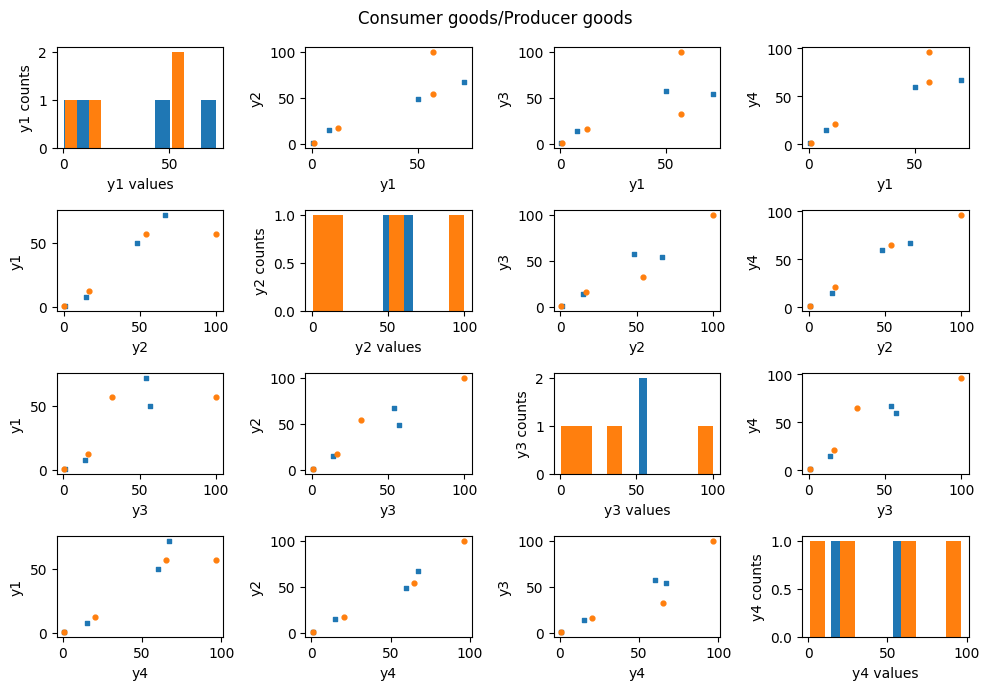

In [4]:
#visualization
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10,7))
for i in range(4):
    for j in range(4):
        if i!=j:
            ax[i][j].scatter(consumer_goods[i], consumer_goods[j], marker='s',s=12)
            ax[i][j].scatter(producer_goods[i], producer_goods[j], marker='o', s=12)
            ax[i][j].set_xlabel('y'+str(i+1))
            ax[i][j].set_ylabel('y'+str(j+1))
            
        else:
            ax[i][j].hist(consumer_goods[i])
            ax[i][j].hist(producer_goods[i])
            ax[i][j].set_ylabel('y'+str(i+1)+' counts')
            ax[i][j].set_xlabel('y'+str(i+1)+' values')

plt.suptitle('Consumer goods/Producer goods')
plt.tight_layout()

In this step we can check is data separable or not.

**Discriminant function**

We should maximize distance between groups:
$$a = \arg\max_a {(\frac{\bar{z}_{1\cdot}-\bar{z}_{2\cdot}}{s_z})}^2$$

Where

$$\arg\max_a {(\frac{\bar{z}_{1\cdot}-\bar{z}_{2\cdot}}{s_z})}^2 = (\bar{y}_{1\cdot} - \bar{y}_{2\cdot})'S_{pl}^{-1}(\bar{y}_{1\cdot} - \bar{y}_{2\cdot})$$


In [5]:
#(a) Find the discriminant function coefficient vector
def get_discriminant(gr1, gr2):
    l1, l2 = gr1.shape[0], gr2.shape[0]
    
    #means
    y1, y2 = np.mean(gr1, axis=0), np.mean(gr2, axis=0)
    
    #pooled covariance
    s1, s2 = np.cov(gr1, rowvar = False), np.cov(gr2, rowvar = False)
    spl = ((l1-1)*s1+(l2-1)*s2)/(l1+l2-2)
    
    a = np.linalg.inv(spl)@(y1-y2)
    z1, z2 = gr1@a, gr2@a
    boundary = (np.mean(z1)+np.mean(z2))/2
    
    return a, boundary, spl

In [6]:
coef, boundary, spl = get_discriminant(consumer_goods, producer_goods)
print(coef, boundary)

[-0.05689601 -0.00970954 -0.24213413 -0.07128274] -7.968630777507048


In [7]:
z = all_goods@coef
gr_ind = z<boundary, z>=boundary
z[gr_ind[0]]=1
z[gr_ind[1]]=2
z

array([2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

In [8]:
consumer_pred = all_goods[gr_ind[1]]
producer_pred = all_goods[gr_ind[0]]

In [9]:
#(b) Find the standardized coefficients.
std_err = np.sqrt(np.diag(np.linalg.inv(spl)))
std_coef = coef/std_err
std_coef

array([-1.199617  , -0.07396723, -0.84662026, -0.02674794])

In [10]:
#(c) Calculate t-tests for individual variables.
res = sts.ttest_ind(consumer_goods, producer_goods)
print('t-values\t', np.round(res.statistic, 4),'\np-values\t', np.round(1-res.pvalue, 4))

t-values	 [-3.7131  0.5494 -3.262  -0.7238] 
p-values	 [0.9983 0.4101 0.9954 0.521 ]


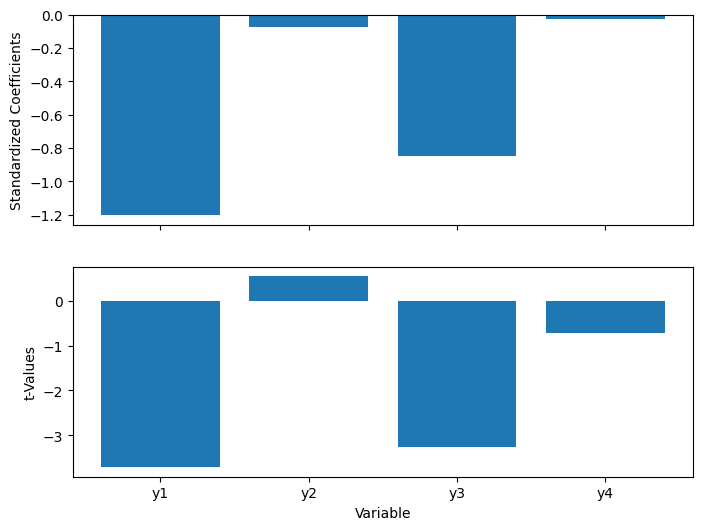

In [11]:
#(d) Compare the results of (b) and (c) as to the contribution of each variable to separation of the groups.

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
ax[0].bar(range(4), std_coef)
ax[0].set_ylabel('Standardized Coefficients')
ax[1].bar(range(4), res.statistic)
ax[1].set_ylabel('t-Values')
ax[1].set_xlabel('Variable')
ax[1].set_xticks(range(4), [f'y{i+1}' for i in range(4)])
plt.show()

In the case of two groups, the partial $F$ is given by
$$F =(\nu-p+1)\frac{T_p^2-T_{p-1}^2}{\nu+T_{p-1}^2} $$

where $T_p^2$ is the two-sample Hotelling $T^2$
with all $p$ variables, 
$T_{p−1}^2$ is the $T^2$-statistic with all variables except $y_r$,
and $\nu = n_1 + n_2 − 2$. 
The F-statistic in is distributed as $F_{1,ν−p+1}$.

-------------------Variable: y1-------------------
calc. F-statistic	F_{1,ν−p+1
	res 3.3315 	 0.0041 	 True
-------------------Variable: y2-------------------
calc. F-statistic	F_{1,ν−p+1
	res 0.0102 	 0.0041 	 True
-------------------Variable: y3-------------------
calc. F-statistic	F_{1,ν−p+1
	res 1.4823 	 0.0041 	 True
-------------------Variable: y4-------------------
calc. F-statistic	F_{1,ν−p+1
	res 0.0013 	 0.0041 	 False


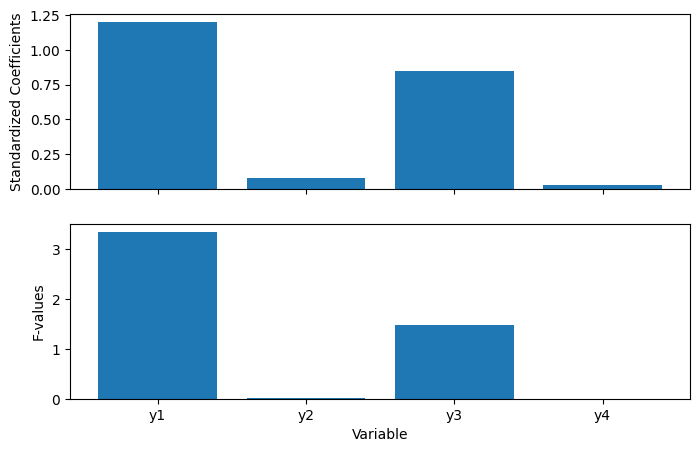

In [12]:
def t2test(A: np.ndarray, B: np.ndarray, alpha: float = .95) -> bool:
    len_A, len_B = A.shape[0], B.shape[0]
    fd_A, fd_B = A.shape[1], B.shape[1] 
    
    # Calculating T^2
    
    # Recieving means
    mean_A, mean_B = np.mean(A, axis=0), np.mean(B, axis=0)
    
    #Receiving pooled covariance
    cov_A, cov_B = np.cov(A, rowvar = False), np.cov(B, rowvar = False)
    pool_cov = ((len_A-1)*cov_A+(len_B-1)*cov_B)/(len_A+len_B-2)
    
    dmean = mean_A-mean_B
    pc_inv = np.linalg.inv(pool_cov)
    t =(len_A*len_B)*dmean@pc_inv@dmean.T/(len_A+len_B)
    
    #check with buil-in function
    _check = (len_A*len_B)*((mahalanobis(mean_A, mean_B, pc_inv))**2)/(len_A+len_B)
    assert abs(_check-t)<1e-3 , 'T^2 check failed'
    
    # Calculating quantile T^2_{a, p, n-1}
    t_ref = sts.f.ppf(1-alpha, fd_A, len_A+len_B-fd_A-1)
    
#     print('calc. T^2\tT^2_{a, p, n-1}\n', np.round(t,4) , '\t', np.round(t_ref, 4))
    
    return t

#(e) Find the partial  𝐹 for each variable
F_all = []
alpha = .95
p = consumer_goods.shape[1]
for i in range(p):
    ind = list(range(p))
    ind.remove(i)
    Tp, Tp1 = t2test(consumer_goods, producer_goods), t2test(consumer_goods[:, ind], producer_goods[:, ind])
    nu = consumer_goods.shape[0]+producer_goods.shape[0]-2
    F = (nu-p+1)*(Tp-Tp1)/(nu+Tp1)
    F_all.append(F)
    F_ref = sts.f.ppf(1-alpha, 1, (nu-p+1))
    print(f'Variable: y{i+1}'.center(50,'-'))
    print('calc. F-statistic\tF_{1,ν−p+1\n\tres', np.round(F,4) , '\t', np.round(F_ref, 4), '\t', F>F_ref)

fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
ax[0].bar(range(4), np.abs(std_coef))
ax[0].set_ylabel('Standardized Coefficients')
ax[1].bar(range(4), F_all)
ax[1].set_ylabel('F-values')
ax[1].set_xlabel('Variable')
ax[1].set_xticks(range(4), [f'y{i+1}' for i in range(4)])
plt.show()

In [13]:
#form vector of real answers
answers = np.array(np.hstack([[2 for i in range(consumer_goods.shape[0])],[1 for i in range(producer_goods.shape[0])]]))

#confussion matrix
cm_df = pd.crosstab(pd.Series(answers.flatten(), name='Actual'), pd.Series(z.flatten(), name='Classified'))
TP, FP, FN, TN = cm_df.to_numpy().flatten()
print('Precision', TP / (TP + FP))
print('Recall', TP / (TP + FN))
cm_df

Precision 0.9
Recall 0.9


Classified,1.0,2.0
Actual,,
1,9,1
2,1,8


**Conclusion**

+ *Consumer goods* and *producer goods* is most separable with $y_2$ and $y_4$
+ the partial $F$’s rank the variables in the same order of importance as the standardized coefficients
+ Precission of classification with discriminant function is $90$%

### Task 2

**8.11** [Rencher p. 312](https://drive.google.com/file/d/163WNrEq6DMY7ryppXldQUmI9A7SEQFh0/view) Using the fish data in Table 6.17, do the following:

**(a)** Find the eigenvectors of $E^{−1}H$.

**(b)** Carry out tests of significance for the discriminant functions and find the
relative importance of each as in (8.13), 
${λ_i}/{\sum{λ_j}}$ .
Do these two procedures agree as to the number of important discriminant functions?

**(c)** Find the standardized coefficients and comment on the contribution of the
variables to separation of groups.

**(d)** Find the partial F for each variable, as in (8.28). Do they rank the variables
in the same order as the standardized coefficients for the first discriminant
function?

**(e)** Plot the first two discriminant functions for each observation and for the
mean vectors.

In [14]:
#Judges’ Scores on Fish Prepared by Three Methods
_annot = "y1 y2 y3 y4 y1 y2 y3 y4 y1 y2 y3 y4"
_data = '''
5.4 6.0 6.3 6.7 5.0 5.3 5.3 6.5 4.8 5.0 6.5 7.0
5.2 6.2 6.0 5.8 4.8 4.9 4.2 5.6 5.4 5.0 6.0 6.4
6.1 5.9 6.0 7.0 3.9 4.0 4.4 5.0 4.9 5.1 5.9 6.5
4.8 5.0 4.9 5.0 4.0 5.1 4.8 5.8 5.7 5.2 6.4 6.4
5.0 5.7 5.0 6.5 5.6 5.4 5.1 6.2 4.2 4.6 5.3 6.3
5.7 6.1 6.0 6.6 6.0 5.5 5.7 6.0 6.0 5.3 5.8 6.4
6.0 6.0 5.8 6.0 5.2 4.8 5.4 6.0 5.1 5.2 6.2 6.5
4.0 5.0 4.0 5.0 5.3 5.1 5.8 6.4 4.8 4.6 5.7 5.7
5.7 5.4 4.9 5.0 5.9 6.1 5.7 6.0 5.3 5.4 6.8 6.6
5.6 5.2 5.4 5.8 6.1 6.0 6.1 6.2 4.6 4.4 5.7 5.6
5.8 6.1 5.2 6.4 6.2 5.7 5.9 6.0 4.5 4.0 5.0 5.9
5.3 5.9 5.8 6.0 5.1 4.9 5.3 4.8 4.4 4.2 5.6 5.5
'''
_ = np.loadtxt(_data.splitlines())
print(_.shape)
method1, method2, method3 = _[:,:4], _[:,4:8], _[:,8:]
all_methods = np.vstack([globals()[f'method{i+1}'] for i in range(3)])
targets = np.hstack([np.array([i for i in range(len(method1))]) for i in range(3)])
print(all_methods.shape, targets.shape)
print(f'method1: {method1.shape}\nmethod2:{method2.shape}\nmethod3:{method3.shape}')

(12, 12)
(36, 4) (36,)
method1: (12, 4)
method2:(12, 4)
method3:(12, 4)


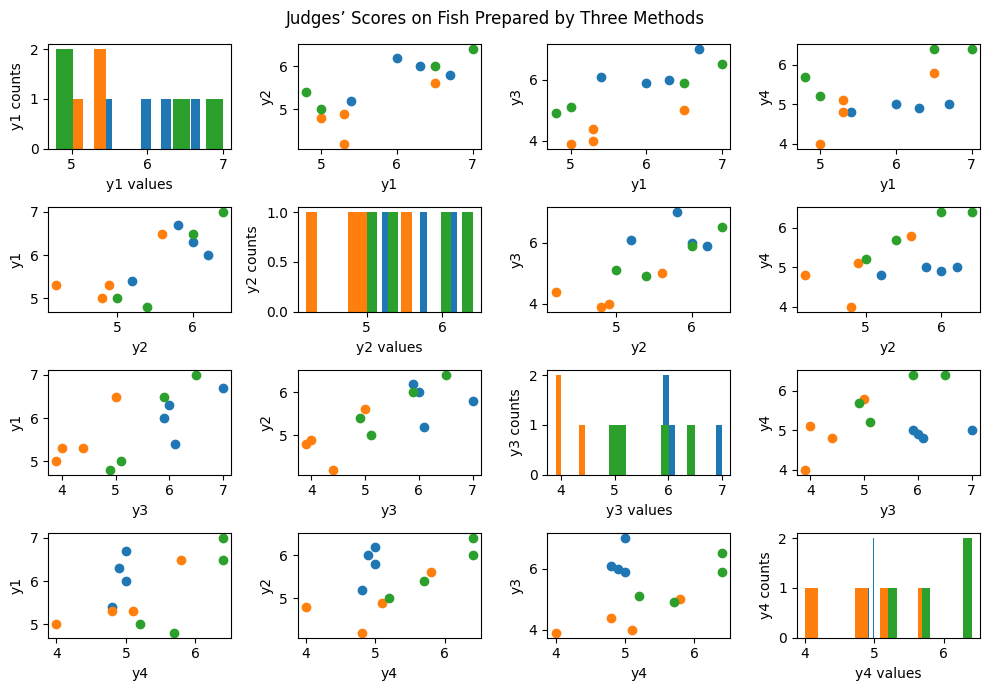

In [15]:
fig, ax = plt.subplots(nrows=4, ncols = 4, figsize=(10,7))
for i in range(3):
    for j in range(4):
        for k in range(4):
            if k==j:
                ax[k][j].hist(globals()[f'method{i+1}'][k])
                ax[k][j].set_ylabel('y'+str(j+1)+' counts')
                ax[k][j].set_xlabel('y'+str(j+1)+' values')
            else:
                ax[k][j].scatter(globals()[f'method{i+1}'][k], globals()[f'method{i+1}'][j])
                ax[k][j].set_xlabel('y'+str(k+1))
                ax[k][j].set_ylabel('y'+str(j+1))

plt.suptitle('Judges’ Scores on Fish Prepared by Three Methods')
plt.tight_layout()

**(a)** Find the eigenvectors of $E^{−1}H$.

\begin{equation}\label{E}
E= \sum_{ij} y_{ij}y_{ij}'- \sum_{i=1}^k \frac{1}{n}\bar{y}_{i\cdot} \bar{y}_{i\cdot}'. 
\end{equation}
\begin{equation}\label{H}
H= \sum_{i=1}^k \frac{1}{n}\bar{y}_{i\cdot} \bar{y}_{i\cdot}'- \frac{1}{kn}y_{\cdot\cdot}y_{\cdot\cdot}'
\end{equation}

In [16]:
p, n, k = method1.shape[1], method1.shape[0], 3
p, n, k

(4, 12, 3)

In [17]:
#Find the eigenvectors of $E^{−1}H (source: https://drive.google.com/file/d/1Zfx1vXY9r8N06Xre6jbalOVjMRFkOS8G/view)
S1 = np.zeros(shape=(p,p))
for i in range(k*n): 
    S1+=(np.array(all_methods[i,:]).reshape(p,1))@(np.array(all_methods[i,:]).reshape(1,p))
g = np.zeros(shape =(k,p))
for i in range(k):
    g[i,:]+= np.sum(all_methods[i*n: (i+1)*n,:], axis = 0)
B= np.zeros(shape=(p,p))
for i in range(3): 
    B+=  (np.array(g[i,:]).reshape((p,1)))  @ (np.array(g[i,:]).reshape((1,p)))
S2 = B/n
E = S1-S2
y_2dot= np.sum(g,axis=0)
D = (np.array(y_2dot.reshape(p,1)))@(np.array(y_2dot.reshape(1,p)))
H= B/n- D/(k*n)

# Calculate eigenvectors of E^-1 * H
eigval, eigvec = np.linalg.eig(np.linalg.inv(E)@H)
idx = eigval.argsort()[::-1]
eigval = eigval[idx]
eigvec = eigvec[:, idx]

print("Matrix E:")
print(E)

print("Matrix H:")
print(H)

print("Eigenvalues:")
print(eigval)

print("Eigenvectors:")
print(eigvec)

Matrix E:
[[13.40833333  7.77833333  8.675       5.86416667]
 [ 7.77833333  8.1025      7.35916667  6.26833333]
 [ 8.675       7.35916667 11.6075      7.0375    ]
 [ 5.86416667  6.26833333  7.0375     10.56583333]]
Matrix H:
[[ 1.05055556  2.12       -1.37555556 -0.76027778]
 [ 2.12        4.605      -2.34       -1.2425    ]
 [-1.37555556 -2.34        2.38222222  1.38444444]
 [-0.76027778 -1.2425      1.38444444  0.81055556]]
Eigenvalues:
[ 3.03556433e+00  1.26104161e-01  2.60652695e-14 -5.45721583e-14]
Eigenvectors:
[[-0.01074921  0.63080853  0.67361429  0.32434251]
 [ 0.84380148 -0.60200855 -0.19837934 -0.15007206]
 [-0.48409948 -0.48437826  0.49275099 -0.43915837]
 [-0.23136812  0.07102114 -0.51389288  0.82426952]]


In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import normalize
model = LinearDiscriminantAnalysis(store_covariance=True)    
model.fit(all_methods, targets)
scaling = model.transform(all_methods)
# scaling = all_methods@normalized_scalings.T

Text(0.5, 1.0, 'Values in the transformed space')

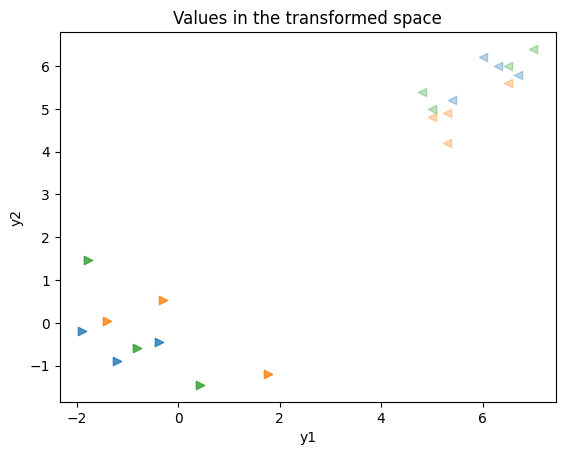

In [19]:
#(e) Plot the first two discriminant functions for each observation and for the mean vectors.
target_names = targets
plt.figure()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for i in range(3):
    plt.scatter(scaling[targets == i, 0], scaling[targets == i, 1], marker='>', alpha=0.8, color=colors[i])
    plt.scatter(globals()[f'method{i+1}'][0], globals()[f'method{i+1}'][1], marker='<', alpha=0.3, color=colors[i])
    plt.xlabel('y1')
    plt.ylabel('y2')
plt.title('Values in the transformed space')

Text(0.5, 1.0, 'Values in the transformed space (with manualy computed weights)')

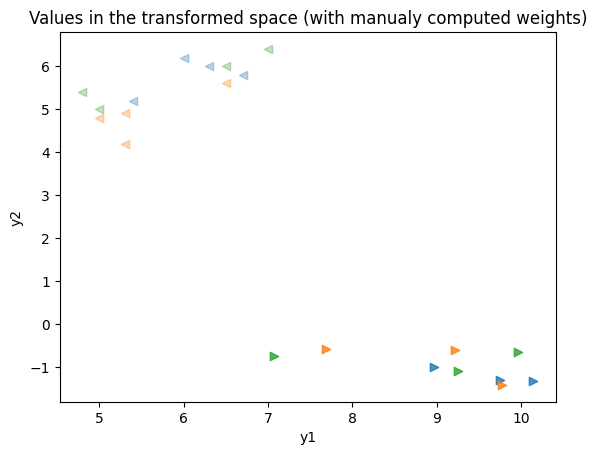

In [20]:
#???
manual_scaling = all_methods@eigvec.T
target_names = targets
plt.figure()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for i in range(3):
    plt.scatter(manual_scaling[targets == i, 0], manual_scaling[targets == i, 1], marker='>', alpha=0.8, color=colors[i])
    plt.scatter(globals()[f'method{i+1}'][0], globals()[f'method{i+1}'][1], marker='<', alpha=0.3, color=colors[i])
    plt.xlabel('y1')
    plt.ylabel('y2')
plt.title('Values in the transformed space (with manualy computed weights)')

In [21]:
#(b) Carry out tests of significance for the discriminant functions and find the relative importance of each
print('Relative importance of each variable:\n')
print(*'y1: y2: y3: y4:'.split(' '), sep='\t ')
print(*np.round(eigval/np.sum(eigval),2), sep='\t ')

Relative importance of each variable:

y1:	 y2:	 y3:	 y4:
0.96	 0.04	 0.0	 -0.0


In [22]:
model.explained_variance_ratio_

array([0.61655031, 0.24333392, 0.10553195, 0.03458381])

In [23]:
print("Eigenvectors")
print(model.scalings_)
print("Normalized")
normalized_scalings = normalize(model.scalings_, axis=0)
print(normalized_scalings)

Eigenvectors
[[ 0.12527425  2.23693471 -0.82744616 -0.5726788 ]
 [ 0.2394159  -0.91754624  0.79691577  1.85546609]
 [ 1.89165956 -0.56689892  1.4080516  -0.5071333 ]
 [-2.9857186   0.32935331  0.09761556 -0.34563646]]
Normalized
[[ 0.03533987  0.89294586 -0.45467644 -0.28120628]
 [ 0.06753923 -0.36626868  0.43790018  0.91110187]
 [ 0.53363719 -0.2262963   0.77371546 -0.24902104]
 [-0.84227127  0.13147218  0.05363913 -0.16972017]]


# Method of head components

**Analyze the number of components by testing the importance of the components**

### Task 1

**12.8** [Rencher p. 422](https://drive.google.com/file/d/163WNrEq6DMY7ryppXldQUmI9A7SEQFh0/view) Carry out a principal component analysis on all six variables of the glucose
data of Table 3.8. Use both $S$ and $R$. Which do you think is more appropriate here? Show the percent of variance explained. Based on the average
eigenvalue or a scree plot, decide how many components to retain. Can you
interpret the components of either $S$ or $R$?

In [24]:
#Blood Glucose Measurements on Three Occasions
_annot = "y1 y2 y3 x1 x2 x3"
_names = 'fasting,after_intake'
_data = '''
60 69 62 97 69 98
56 53 84 103 78 107
80 69 76 66 99 130
55 80 90 80 85 114
62 75 68 116 130 91
74 64 70 109 101 103
64 71 66 77 102 130
73 70 64 115 110 109
68 67 75 76 85 119
69 82 74 72 133 127
60 67 61 130 134 121
70 74 78 150 158 100
66 74 78 150 131 142
83 70 74 99 98 105
68 66 90 119 85 109
78 63 75 164 98 138
103 77 77 160 117 121
77 68 74 144 71 153
66 77 68 77 82 89
70 70 72 114 93 122
75 65 71 77 70 109
91 74 93 118 115 150
66 75 73 170 147 121
75 82 76 153 132 115
74 71 66 143 105 100
76 70 64 114 113 129
74 90 86 73 106 116
74 77 80 116 81 77
67 71 69 63 87 70
78 75 80 105 132 80
64 66 71 83 94 133
71 80 76 81 87 86
63 75 73 120 89 59
90 103 74 107 109 101
60 76 61 99 111 98
48 77 75 113 124 97
66 93 97 136 112 122
74 70 76 109 88 105
60 74 71 72 90 71
63 75 66 130 101 90
66 80 86 130 117 144
77 67 74 83 92 107
70 67 100 150 142 146
73 76 81 119 120 119
78 90 77 122 155 149
73 68 80 102 90 122
72 83 68 104 69 96
65 60 70 119 94 89
52 70 76 92 94 100
'''
_ = np.loadtxt(_data.splitlines())
for name, ind in zip(_names.split(','),[(0,3),(3,6)]):
    globals()[name]=_[:,ind[0]:ind[1]]
    print(f'{name}: {globals()[name].shape}')

fasting: (49, 3)
after_intake: (49, 3)


In [25]:
glucose_measurements=np.vstack([fasting, after_intake])
glucose_measurements.shape

(98, 3)

Explained variance:	 [0.78723646 0.12212563 0.09063791]


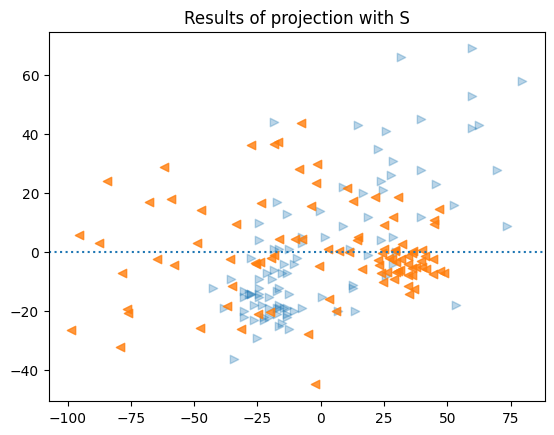

In [26]:
glucose_measurements_mean = np.mean(glucose_measurements, axis=0)
glucose_measurements_cov = np.cov(glucose_measurements, rowvar = False)

#Symetrization
glucose_measurements_sym_ = glucose_measurements - glucose_measurements_mean
S = glucose_measurements_cov

eigval_S, eigvec_S = np.linalg.eig(S)
#Sorting
idx = eigval_S.argsort()[::-1]
# eigval = eigval[idx]
eigvec_S = eigvec_S[:, idx]

#Explained variance
var_exp_S = eigval_S / np.sum(eigval_S)
print('Explained variance:\t', var_exp_S)

#Rotating
z1 = glucose_measurements_sym_@eigvec_S[:,0]
z2 = glucose_measurements_sym_@eigvec_S[:,1]

plt.title('Results of projection with S')
plt.scatter(glucose_measurements_sym_[:, 0], glucose_measurements_sym_[:, 1], marker='>', alpha=0.3)
plt.scatter(z1, z2, marker='<', alpha=0.8)
plt.axhline(0, linestyle=':')

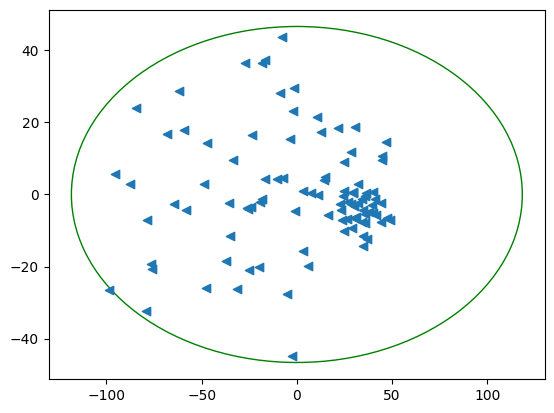

In [27]:
from matplotlib.patches import Ellipse
#Building of ellipse
a, b, *_ = np.sqrt(eigval_S[idx])
fig, ax = plt.subplots()
patch = Ellipse(xy=(0,0), width= 3*2*a,  height= 3*2*b, edgecolor='g', fc='None')
ax.add_patch(patch)
ax.scatter(z1,z2, marker='<') 
ax.autoscale()

Text(0.5, 1.0, 'Scree Plot for S')

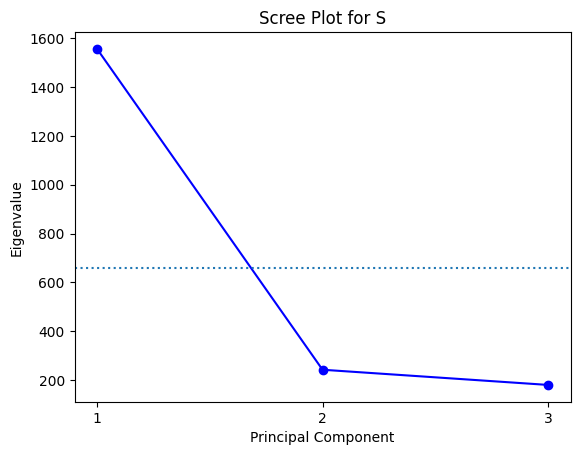

In [28]:
# Average eigenvalue criterion
mean_eigval_S = np.mean(eigval_S)
plt.plot(np.arange(1, len(eigval_S)+1), eigval_S, 'bo-')
plt.axhline(mean_eigval_S, linestyle = ':')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.xticks(range(1,glucose_measurements_sym_.shape[1]+1))
plt.title('Scree Plot for S')

Explained variance:	 [0.9500949  0.03600143 0.01390367]


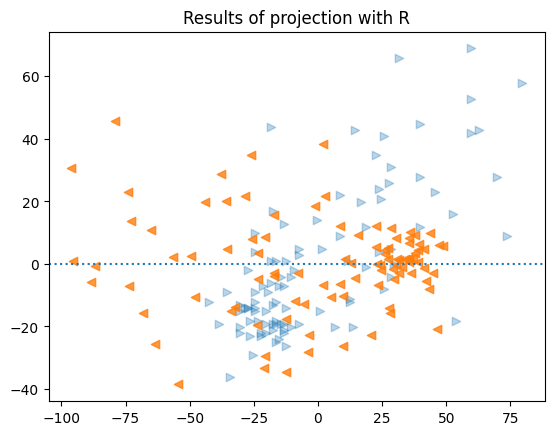

In [29]:
R = np.corrcoef(glucose_measurements_sym_.T)
U, s, Vt = np.linalg.svd(R)
eigvec_R = Vt.T
eigval_R = s**2 / (glucose_measurements_sym_[0] - 1)
#Explained variance
var_exp_R = eigval_R / np.sum(eigval_R)
print('Explained variance:\t', var_exp_R)

#Rotating
z1_R = glucose_measurements_sym_@eigvec_R[:,0]
z2_R = glucose_measurements_sym_@eigvec_R[:,1]

plt.title('Results of projection with R')
plt.scatter(glucose_measurements_sym_[:, 0], glucose_measurements_sym_[:, 1], marker='>', alpha=0.3)
plt.scatter(z1_R, z2_R, marker='<', alpha=0.8)
plt.axhline(0, linestyle=':')

Text(0.5, 1.0, 'Scree Plot')

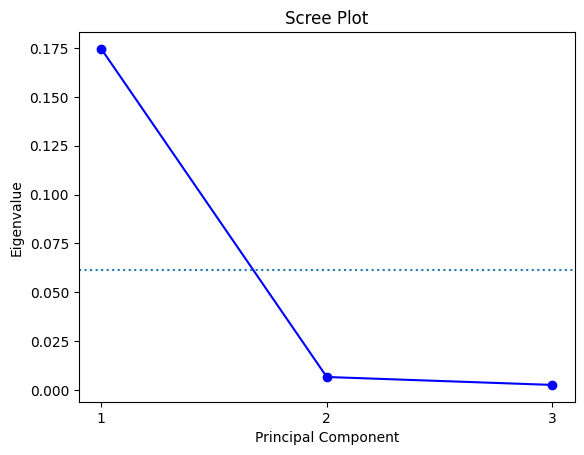

In [30]:
# Average eigenvalue criterion
mean_eigval_R = np.mean(np.abs(eigval_R))
plt.plot(np.arange(1, len(eigval_R)+1), np.abs(eigval_R), 'bo-')
plt.axhline(mean_eigval_R, linestyle = ':')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.xticks(range(1,glucose_measurements_sym_.shape[1]+1))
plt.title('Scree Plot')

**Conclusion**
+ Using the scree plot optimal value for *n_components* is $2$ in both cases
+ For represented data is more appropriate using of covariation matrix $R$

### Task 2

**12.10** [Rencher p. 422](https://drive.google.com/file/d/163WNrEq6DMY7ryppXldQUmI9A7SEQFh0/view) Carry out a principal component analysis separately for males and females in
the psychological data of Table 5.1. Compare the results for the two groups.
Use $S$.

In [31]:
#Four Psychological Test Scores on 32 Males and 32 Females
_annot = "y1 y2 y3 y4 y1 y2 y3 y4"
_names = 'Males, Females'.lower().replace(' ','')
_data = '''
15 17 24 14 13 14 12 21
17 15 32 26 14 12 14 26
15 14 29 23 12 19 21 21
13 12 10 16 12 13 10 16
20 17 26 28 11 20 16 16
15 21 26 21 12 9 14 18
15 13 26 22 10 13 18 24
13 5 22 22 10 8 13 23
14 7 30 17 12 20 19 23
17 15 30 27 11 10 11 27
17 17 26 20 12 18 25 25
17 20 28 24 14 18 13 26
15 15 29 24 14 10 25 28
18 19 32 28 13 16 8 14
18 18 31 27 14 8 13 25
15 14 26 21 13 16 23 28
18 17 33 26 16 21 26 26
10 14 19 17 14 17 14 14
18 21 30 29 16 16 15 23
18 21 34 26 13 16 23 24
13 17 30 24 2 6 16 21
16 16 16 16 14 16 22 26
11 15 25 23 17 17 22 28
16 13 26 16 16 13 16 14
16 13 23 21 15 14 20 26
18 18 34 24 12 10 12 9
16 15 28 27 14 17 24 23
15 16 29 24 13 15 18 20
18 19 32 23 11 16 18 28
18 16 33 23 7 7 19 18
17 20 21 21 12 15 7 28
19 19 30 28 6 5 6 13
'''
_ = np.loadtxt(_data.splitlines())
for name, ind in zip(_names.split(','),[(0,4),(4,8)]):
    globals()[name]=_[:,ind[0]:ind[1]]
    print(f'{name}: {globals()[name].shape}')

males: (32, 4)
females: (32, 4)


Explained variance for males:	 [0.68393433 0.03957813 0.17486597 0.10162156]
Explained variance for females:	 [0.57074356 0.05617076 0.21525468 0.157831  ]


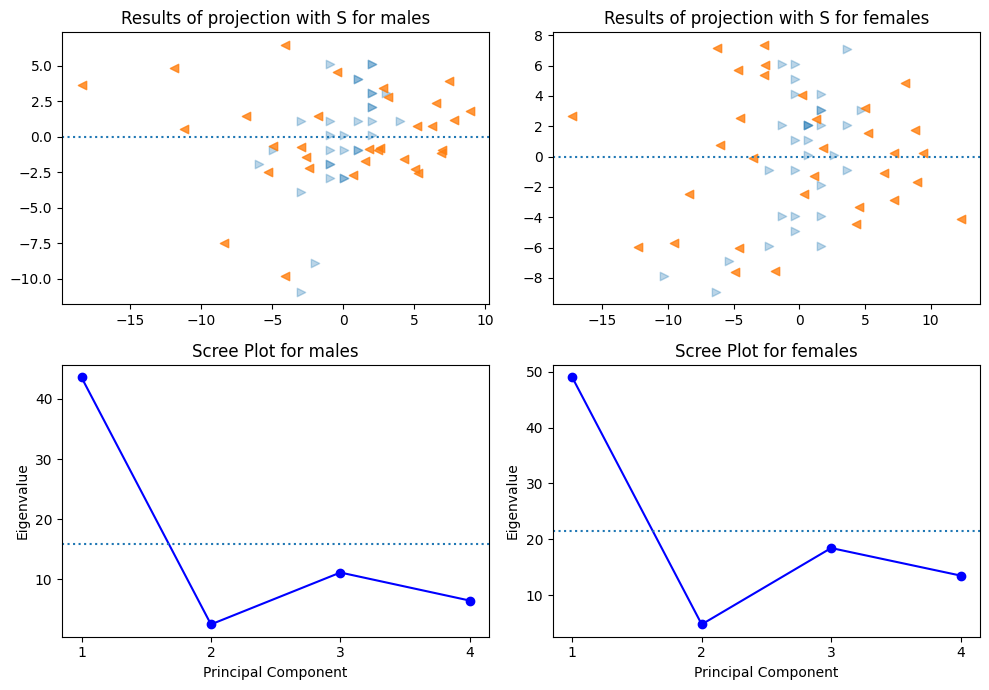

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
for i, name in enumerate(_names.split(',')):
    globals()[name+'_mean'] = np.mean(globals()[name], axis=0)
    globals()[name+'_cov'] = np.cov(globals()[name], rowvar = False)

    #Symetrization
    globals()[name+'_sym_'] = globals()[name] - globals()[name+'_mean']
    S = globals()[name+'_cov']

    globals()[name+'eigval'], globals()[name+'eigvec'] = np.linalg.eig(S)
    #Sorting
    idx = globals()[name+'eigval'].argsort()[::-1]
#     eigval = eigval[idx]
    globals()[name+'eigvec'] = globals()[name+'eigvec'][:, idx]

    #Explained variance
    var_exp = globals()[name+'eigval'] / np.sum(globals()[name+'eigval'])
    print(f'Explained variance for {name}:\t', var_exp)

    #Rotating
    z1 = globals()[name+'_sym_']@globals()[name+'eigvec'][:,0]
    z2 = globals()[name+'_sym_']@globals()[name+'eigvec'][:,1]

    ax[0][i].set_title(f'Results of projection with S for {name}')
    ax[0][i].scatter(globals()[name+'_sym_'][:, 0], globals()[name+'_sym_'][:, 1], marker='>', alpha=0.3)
    ax[0][i].scatter(z1, z2, marker='<', alpha=0.8)
    ax[0][i].axhline(0, linestyle=':')
    
    mean_eigval = np.mean(globals()[name+'eigval'])
    ax[1][i].plot(np.arange(1, len(globals()[name+'eigval'])+1), globals()[name+'eigval'], 'bo-')
    ax[1][i].axhline(mean_eigval, linestyle = ':')
    ax[1][i].set_xlabel('Principal Component')
    ax[1][i].set_ylabel('Eigenvalue')
    ax[1][i].set_xticks(range(1,globals()[name+'_sym_'].shape[1]+1))
    ax[1][i].set_title(f'Scree Plot for {name}')

plt.tight_layout()

**Conclusion**

PCA gives better results for males dataset based on explained variance

### Task 3
Take an image and compress it using the principal components method.

![](https://lh3.googleusercontent.com/drive-viewer/AFGJ81o6gydXdAPROCOqiurLK9plH4Yp19PLK9WOyCP039FexUzEgOAu-BKo8YQCOzSqbsqpdzNunW-yOxuxjzlhqyo2F_qw=w1123-h941)

Raw size (bytes)	 155062
Shape 679 1024 3
Saved PIL image (bytes)	 157438
Saved OpenCV BGR image (bytes) 222485
Saved OpenCV RGB image (bytes) 222485


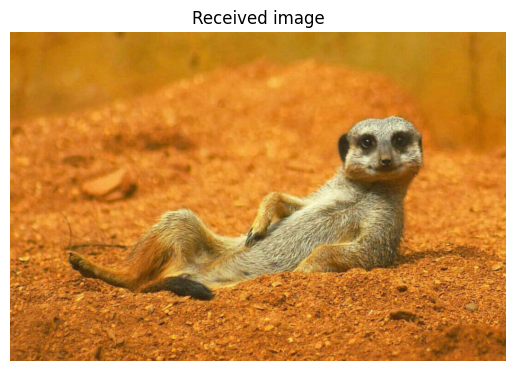

In [33]:
!pip install urllib3
import cv2 as cv
from PIL import Image
import io, os
from sklearn.decomposition import PCA
from urllib.request import Request, urlopen

def get_buffer_size(im):
    is_success, buffer = cv.imencode(".jpg", cv_img_bgr)
    img_file = io.BytesIO(buffer)
    return img_file.getbuffer().nbytes

url = 'https://lh3.googleusercontent.com/drive-viewer/AFGJ81o6gydXdAPROCOqiurLK9plH4Yp19PLK9WOyCP039FexUzEgOAu-BKo8YQCOzSqbsqpdzNunW-yOxuxjzlhqyo2F_qw=w1123-h941'
request = Request(url)
html = urlopen(request).read()
img_raw = bytearray(html)
print('Raw size (bytes)\t', len(img_raw))
arr = np.asarray(img_raw, dtype=np.uint8)
cv_img_bgr = cv.imdecode(arr, -1)
cv_img_rgb = cv.cvtColor(cv_img_bgr, cv.COLOR_BGR2RGB) #color convertation
pil_img = Image.open(io.BytesIO(img_raw))
plt.imshow(cv_img_rgb)
plt.axis('off')
plt.title('Received image')
im_w, im_h, num_ch = cv_img_rgb.shape
print('Shape', im_w, im_h, num_ch)

img_file = io.BytesIO()
pil_img.save(img_file, 'jpeg', quality='keep')
print('Saved PIL image (bytes)\t', img_file.getbuffer().nbytes)

print('Saved OpenCV BGR image (bytes)', get_buffer_size(cv_img_bgr))
print('Saved OpenCV RGB image (bytes)', get_buffer_size(cv_img_rgb))

**Size difference between PIL and CV**

According to [documentation](https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#jpeg-saving) PIL uses bigger compression (75%) than OpenCV (95%) ([doc](https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html?highlight=imwrite#imwrite))

*I received information directly from disk so true size of image is size of response (raw size)*

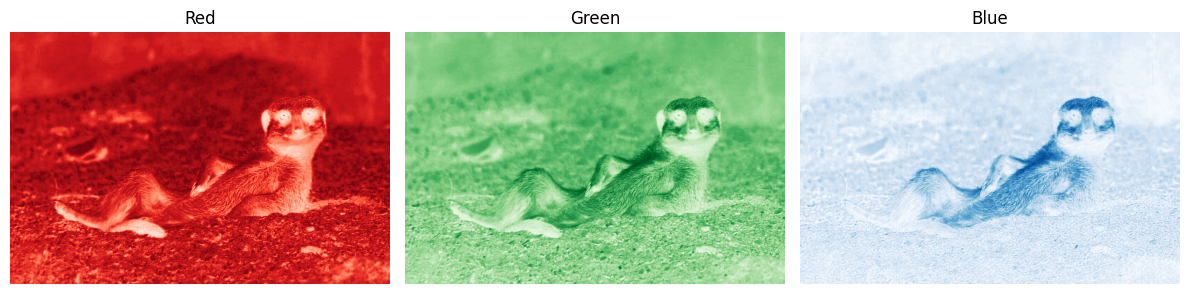

In [34]:
_ch_names =['Red','Green', 'Blue']
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
img_channels = cv.split(cv_img_rgb)
for i, ch_name in enumerate(_ch_names):
    ax[i].axis('off')
    ax[i].imshow(img_channels[i], cmap=ch_name+'s')
    ax[i].set_title(ch_name)
plt.tight_layout()

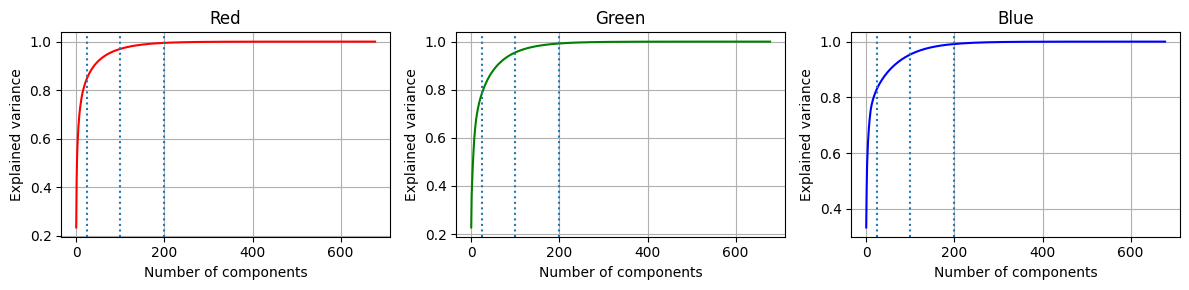

In [35]:
#scaling channels
testing_components = [25,100, 200]

img_channels = np.array(img_channels)/255
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
for i, ch_name in enumerate(_ch_names):
    pca = PCA().fit(cv_img_rgb[:,:,i])
    ax[i].grid()
    ax[i].plot(np.cumsum(pca.explained_variance_ratio_), c=ch_name)
    for _value in testing_components:
        ax[i].axvline(_value, linestyle=':')
    ax[i].set_xlabel('Number of components')
    ax[i].set_ylabel('Explained variance')
    ax[i].set_title(ch_name)
plt.tight_layout()

-----Explained variance for n_components = 25-----
Red:	 0.8467475175515202
Green:	 0.7836882855123622
Blue:	 0.8297085986575002
Total loss: 0.5398555982786173
Restored image size (bytes) 222485
Array sizes: 50925 2085888 2.44%
----Explained variance for n_components = 100-----
Red:	 0.9693423181938605
Green:	 0.9538694482327401
Blue:	 0.9528081596939741
Total loss: 0.12398007387942522
Restored image size (bytes) 222485
Array sizes: 203700 2085888 9.77%
----Explained variance for n_components = 200-----
Red:	 0.9947389927724111
Green:	 0.9921703663343848
Blue:	 0.9913271931959737
Total loss: 0.021763447697230376
Restored image size (bytes) 222485
Array sizes: 407400 2085888 19.53%


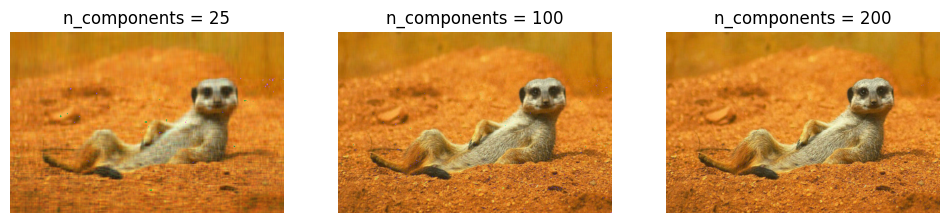

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
for i, n_components in enumerate(testing_components):
    pca = [PCA(n_components).fit(cv_img_rgb[:,:,i]) for i in range(num_ch)]
    new_img = [pca[i].transform(cv_img_rgb[:,:,i]) for i in range(num_ch)]
    
    print(f'Explained variance for n_components = {n_components}'.center(50,'-'))
    print(*[f'{_ch_names[i]}:\t {np.sum(pca[i].explained_variance_ratio_)}' for i in range(num_ch)],sep='\n')
    print('Total loss:',sum([1-np.sum(pca[i].explained_variance_ratio_) for i in range(num_ch)]))

    restored = cv.merge([pca[i].inverse_transform(new_img[i]) for i in range(num_ch)]).astype(np.uint8)
    ax[i].set_title(f'n_components = {n_components}')
    ax[i].imshow(restored)
    ax[i].axis('off')
    print('Restored image size (bytes)', get_buffer_size(restored))
    print('Array sizes:', np.vstack(new_img).size, cv_img_rgb.size, '%.2f%%'%(100*np.vstack(new_img).size/cv_img_rgb.size))

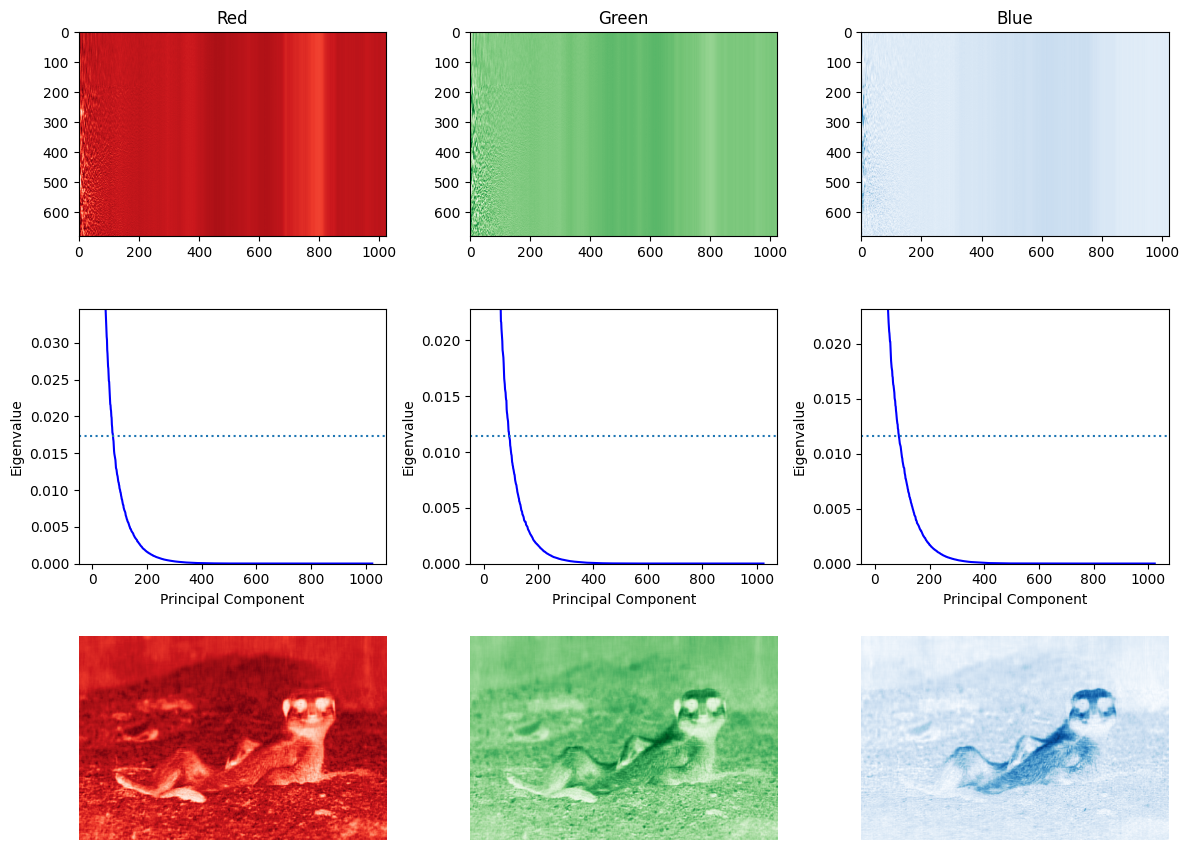

(-0.5, 1023.5, 678.5, -0.5)

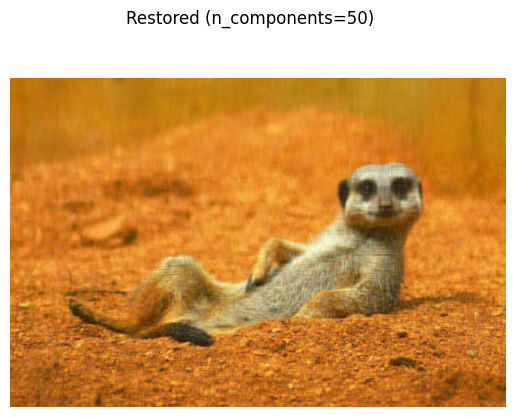

In [37]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,9))
n_components=50
restored_image = []
for i, ch_name in enumerate(_ch_names):
    # Manual calculation
    ch_mean = np.mean(img_channels[i], axis=0)
    ch_cov = np.cov(img_channels[i], rowvar = False)

    #Symetrization
    ch_sym_ = img_channels[i] - ch_mean
    S = ch_cov

    eigval_S, eigvec_S = np.linalg.eig(S)
    #Sorting
    idx = eigval_S.argsort()[::-1]
    eigval_S = eigval_S[idx]
    eigvec_S = eigvec_S[:, idx]

    #Explained variance
    var_exp_S = eigval_S / np.sum(eigval_S)

    eigvec, eigval = eigvec_S, eigval_S
    
    #Rotating
    z = ch_sym_@eigvec.real+ch_mean
    z*=255
    z = np.uint8(np.clip(z, 0, 255))
    
    ax[0][i].set_title(ch_name)
    ax[0][i].imshow(z, cmap=ch_name+'s')

    
    mean_eigval = np.mean(eigval.real)
    ax[1][i].plot(np.arange(1, len(eigval.real)+1), np.abs(eigval.real), 'b-')
    ax[1][i].axhline(np.abs(mean_eigval), linestyle = ':')
    ax[1][i].set_xlabel('Principal Component')
    ax[1][i].set_ylabel('Eigenvalue')
    ax[1][i].set_xticks(range(0,ch_sym_.shape[1]+1, 200))
    ax[1][i].set_ylim(0,np.abs(mean_eigval)*2)
    
    loadings = eigvec[:,:n_components]
    z_reverse = (ch_sym_@loadings)@loadings.T + ch_mean
    z_reverse *=255
    z_reverse = np.uint8(np.clip(z_reverse.real, 0, 255))

    ax[2][i].imshow(z_reverse, cmap=ch_name+'s')
    ax[2][i].axis('off')
    restored_image.append(np.abs(z_reverse))
plt.tight_layout()
plt.show()
plt.suptitle(f'Restored (n_components={n_components})')
plt.imshow(cv.merge(restored_image).astype(np.uint8))
plt.axis('off')

# Classification

Make classification of data

**(1)** By Linear Regression

**(2)** By Gauss model

**(a)** 4 column By 2-3 columns 

**(b)** 4 column by first 3 (k-means)

In [161]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

In [38]:
url = 'https://drive.google.com/uc?id=1tlE_Hos7tCznjZtNs9zNh9byWQDt4-_n&export=download'
request = Request(url)
html = urlopen(request)
data_df = pd.read_table(html, sep=',', index_col=0)
data_df = data_df.loc[:, ~data_df.columns.str.contains('^Unnamed')]
#choosing first 4 columns
data_df = data_df[data_df.columns[:4]]
print(data_df.info)
print(data_df.head())
print(data_df.describe())

<bound method DataFrame.info of           Gender  Age  EstimatedSalary  Purchased
User ID                                          
15624510    Male   19            19000          0
15810944    Male   35            20000          0
15668575  Female   26            43000          0
15603246  Female   27            57000          0
15804002    Male   19            76000          0
...          ...  ...              ...        ...
15691863  Female   46            41000          1
15706071    Male   51            23000          1
15654296  Female   50            20000          1
15755018    Male   36            33000          0
15594041  Female   49            36000          1

[400 rows x 4 columns]>
          Gender  Age  EstimatedSalary  Purchased
User ID                                          
15624510    Male   19            19000          0
15810944    Male   35            20000          0
15668575  Female   26            43000          0
15603246  Female   27            57000     

In [39]:
print('Genders:', np.unique(data_df.Gender, return_counts=True))
data_df.Gender = (data_df.Gender=='Male').astype(np.uint8)
print('Converted classes:', np.unique(data_df.Gender, return_counts=True))

Genders: (array(['Female', 'Male'], dtype=object), array([204, 196], dtype=int64))
Converted classes: (array([0, 1], dtype=uint8), array([204, 196], dtype=int64))


**(a)**

*Note:* here confusion matrix, spliting and metrics calculation realeased with using NumPy and Pandas. In next section **(b)** Sklearn methods'll be used. 

In [104]:
def print_evaluate(y_test, y_pred):
    
    #confussion matrix
    # cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.crosstab(pd.Series(y_test.flatten(), name='Actual'), pd.Series(y_pred.flatten(), name='Classified')) 
    
    # metrics
    TP, FP, FN, TN = cm_df.to_numpy().flatten()
    # acc = accuracy_score(y_test,y_pred)
    precission = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (y_test==y_pred).sum()/len(y_test)
    print('Precision', precission)
    print('Recall', recall)
    print('Accuracy', accuracy)
    cm_df
    sns.heatmap(cm_df.to_numpy(), annot=True, cmap='coolwarm')
    plt.show()
    
    return precission, recall, accuracy

In [129]:
_feature_names = data_df.columns[1:3].to_list()
y = data_df.Purchased.to_numpy()
X = data_df[_feature_names].to_numpy()
print('Shapes:', X.shape, y.shape)
print('Features:', _feature_names)
print('Names of classes:', np.unique(y, return_counts=True))

Shapes: (400, 2) (400,)
Features: ['Age', 'EstimatedSalary']
Names of classes: (array([0, 1], dtype=int64), array([257, 143], dtype=int64))


In [130]:
size = 0.8
_size_ind = int(len(X)*size)
#Shuffle
_= np.random.permutation(len(X))
X = X[_]
y = y[_]
X_train, y_train, X_test, y_test = X[:_size_ind], y[:_size_ind], X[_size_ind:], y[_size_ind:]
print(*zip('X_train, y_train, X_test, y_test'.split(', '), map(np.shape,[X_train, y_train, X_test, y_test])), sep='\n')

('X_train', (320, 2))
('y_train', (320,))
('X_test', (80, 2))
('y_test', (80,))


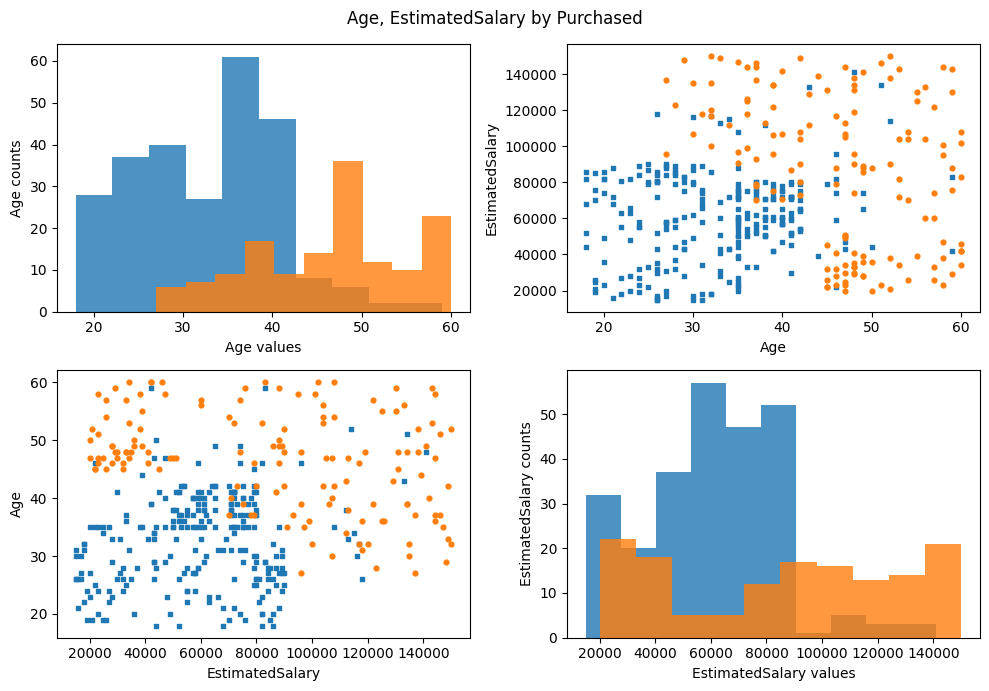

In [159]:
#visualization
fig, ax = plt.subplots(nrows=len(_feature_names), ncols=len(_feature_names), figsize=(10,7))
for i in range(len(_feature_names)):
    for j in range(len(_feature_names)):
        if i!=j:
            ax[i][j].scatter(X[y==0,i], X[y==0,j], marker='s',s=12)
            ax[i][j].scatter(X[y==1,i], X[y==1,j], marker='o', s=12)
            ax[i][j].set_xlabel(_feature_names[i])
            ax[i][j].set_ylabel(_feature_names[j])
            
        else:
            ax[i][j].hist(X[y==0,i], alpha=.8)
            ax[i][j].hist(X[y==1,i], alpha=.8)
            ax[i][j].set_ylabel(_feature_names[i]+' counts')
            ax[i][j].set_xlabel(_feature_names[i]+' values')

plt.suptitle(f'{", ".join(_feature_names)} by Purchased')
plt.tight_layout()

**(1)** by linear regression

Precision 0.9375
Recall 0.7894736842105263
Accuracy 0.8125


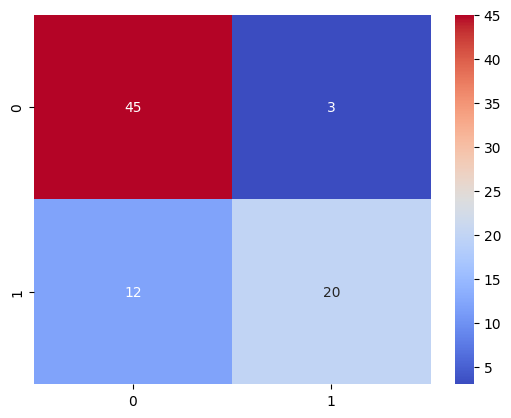

In [132]:
bin_model = LinearDiscriminantAnalysis()    
bin_model.fit(X_train, y_train)
y_pred = bin_model.predict(X_test)

bin_metrics = print_evaluate(y_test, y_pred)

In [133]:
class LinearClassifier():
    def __init__(self):
        self.w = None
        self.boundary = None
        
    def fit(self, X_train, y_train):
        self.w, self.boundary, _ = get_discriminant(X_train[y_train==0, :], X_train[y_train==1, :])
        
    def predict(self, X_test):
        y_pred = X_test@self.w
        gr_ind = y_pred<self.boundary, y_pred>=self.boundary
        y_pred[gr_ind[0]]=1
        y_pred[gr_ind[1]]=0
        return y_pred

Precision 0.8958333333333334
Recall 0.8775510204081632
Accuracy 0.8625


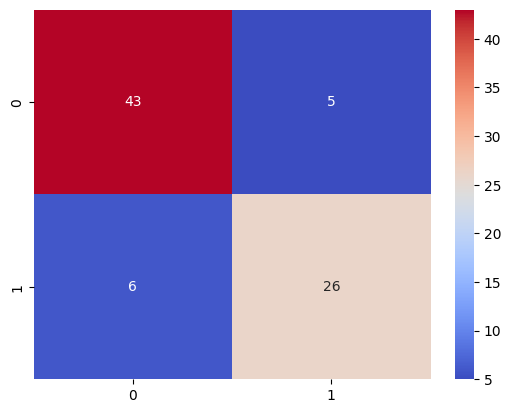

In [134]:
model = LinearClassifier()    
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

m_metrics = print_evaluate(y_test, y_pred)

            Sklearn lin. classifier  Our lin. classifier
Precission                 0.937500             0.895833
Recall                     0.789474             0.877551
Accuracy                   0.812500             0.862500


<Axes: >

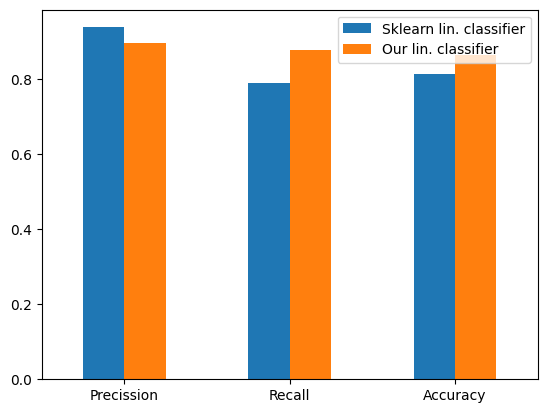

In [135]:
comparsion = pd.DataFrame({'Sklearn lin. classifier': pd.Series(bin_metrics), 
'Our lin. classifier': pd.Series(m_metrics)})
comparsion.index=pd.Series(['Precission', 'Recall', 'Accuracy'])
print(comparsion)
comparsion.plot.bar(rot=0)

**(2)** By Gauss model

Precision 0.9375
Recall 0.8181818181818182
Accuracy 0.8375


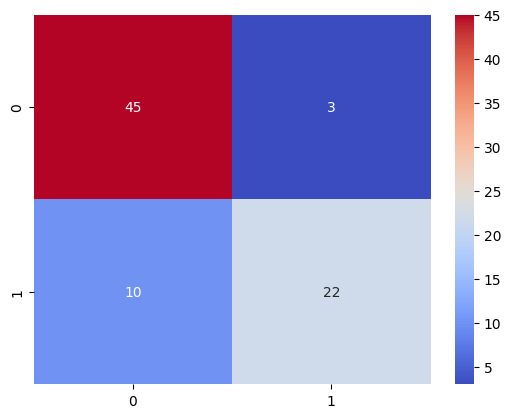

In [137]:
bin_model = GaussianNB()   
bin_model.fit(X_train, y_train)
y_pred = bin_model.predict(X_test)

bin_metrics = print_evaluate(y_test, y_pred)

In [154]:
class BayesClassifier():
    mv_norm = lambda self, z, m, s: -.5*np.log(np.linalg.det(s)) - np.dot((z-m).T, np.dot(np.linalg.inv(s),z-m))
    
    def __init__(self):
        self.X_means = None
        self.X_covs = None

    def fit(self, X, y):
        assert X.shape[0]==y.shape[0], f'Shapes are to equal: X{X.shape}, y{y.shape}'
        
        _classes = np.unique(y)
        
        self.X_means = [np.mean(X[y==_class, :], axis=0) for _class in _classes]
        self.X_covs = [np.cov(X[y==_class, :], rowvar=False) for _class in _classes]
        
        pass
    def predict(self, X_test):
        y_pred = []
        k = 0
        for i in range(len(X_test)): 
            z = X_test[i,:]
            if self.mv_norm(z,self.X_means[0],self.X_covs[0]) > self.mv_norm(z,self.X_means[1],self.X_covs[1]): 
                y_pred.append(0)
                k+=1
            else: 
                y_pred.append(1)
        return np.array(y_pred)

Precision 0.8958333333333334
Recall 0.9772727272727273
Accuracy 0.925


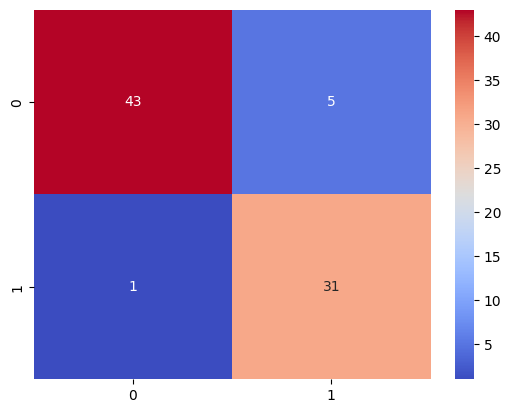

In [155]:
model = BayesClassifier()   
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

m_metrics = print_evaluate(y_test, y_pred)

            Sklearn Bayes classifier  Our Bayes classifier
Precission                  0.937500              0.895833
Recall                      0.818182              0.977273
Accuracy                    0.837500              0.925000


<Axes: >

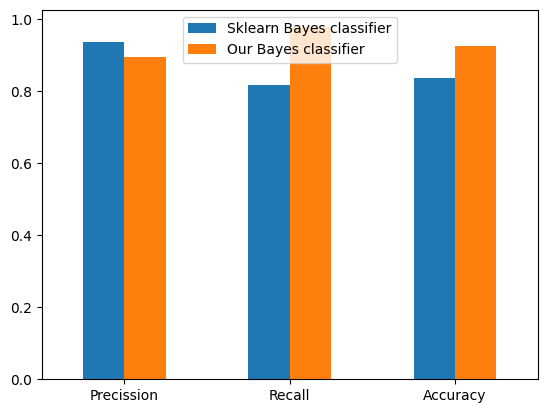

In [156]:
comparsion = pd.DataFrame({'Sklearn Bayes classifier': pd.Series(bin_metrics), 
'Our Bayes classifier': pd.Series(m_metrics)})
comparsion.index=pd.Series(['Precission', 'Recall', 'Accuracy'])
print(comparsion)
comparsion.plot.bar(rot=0)

**(b)** 

In [177]:
# overload with Sklearn methods
def print_evaluate(y_test, y_pred):
    #confussion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # metrics
    accuracy = accuracy_score(y_test,y_pred)
    precission = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    print('Precision', precission)
    print('Recall', recall)
    print('Accuracy', accuracy)

    sns.heatmap(cm, annot=True, cmap='coolwarm')
    plt.show()
    
    return precission, recall, accuracy

In [182]:
_feature_names = data_df.columns[0:3].to_list()
y = data_df.Purchased.to_numpy()
X = data_df[_feature_names].to_numpy()
print('Shapes:', X.shape, y.shape)
print('Features:', _feature_names)
print('Names of classes:', np.unique(y, return_counts=True))

Shapes: (400, 3) (400,)
Features: ['Gender', 'Age', 'EstimatedSalary']
Names of classes: (array([0, 1], dtype=int64), array([257, 143], dtype=int64))


In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
print(*zip('X_train, y_train, X_test, y_test'.split(', '), map(np.shape,[X_train, y_train, X_test, y_test])), sep='\n')

('X_train', (320, 3))
('y_train', (320,))
('X_test', (80, 3))
('y_test', (80,))


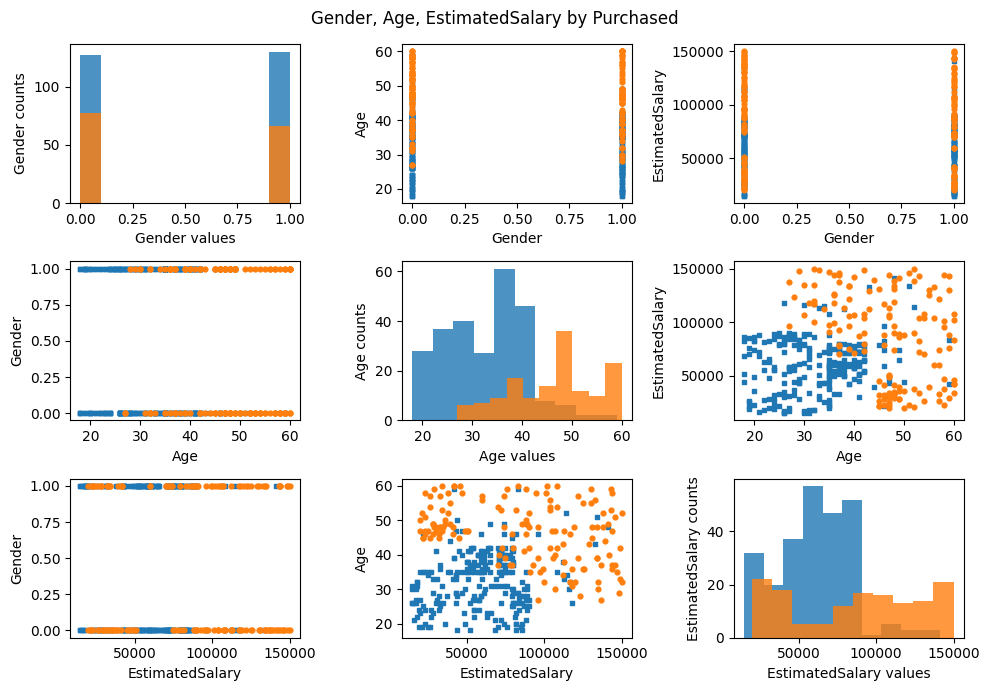

In [188]:
#visualization
fig, ax = plt.subplots(nrows=len(_feature_names), ncols=len(_feature_names), figsize=(10,7))
for i in range(len(_feature_names)):
    for j in range(len(_feature_names)):
        if i!=j:
            ax[i][j].scatter(X[y==0,i], X[y==0,j], marker='s',s=12)
            ax[i][j].scatter(X[y==1,i], X[y==1,j], marker='o', s=12)
            ax[i][j].set_xlabel(_feature_names[i])
            ax[i][j].set_ylabel(_feature_names[j])
            
        else:
            ax[i][j].hist(X[y==0,i], alpha=.8)
            ax[i][j].hist(X[y==1,i], alpha=.8)
            ax[i][j].set_ylabel(_feature_names[i]+' counts')
            ax[i][j].set_xlabel(_feature_names[i]+' values')

plt.suptitle(f'{", ".join(_feature_names)} by Purchased')
plt.tight_layout()

In [174]:
# #Standartization
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

Precision 0.8947368421052632
Recall 0.7727272727272727
Accuracy 0.9125


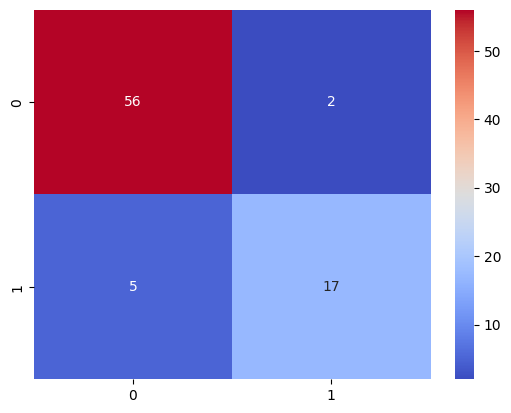

Precision 0.8260869565217391
Recall 0.8636363636363636
Accuracy 0.9125


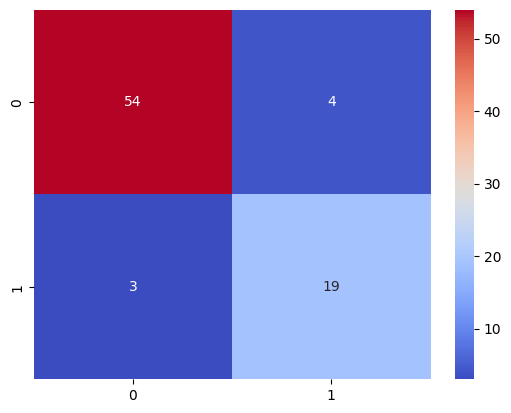

            Sklearn lin. classifier  Our lin. classifier
Precission                 0.894737             0.826087
Recall                     0.772727             0.863636
Accuracy                   0.912500             0.912500


<Axes: >

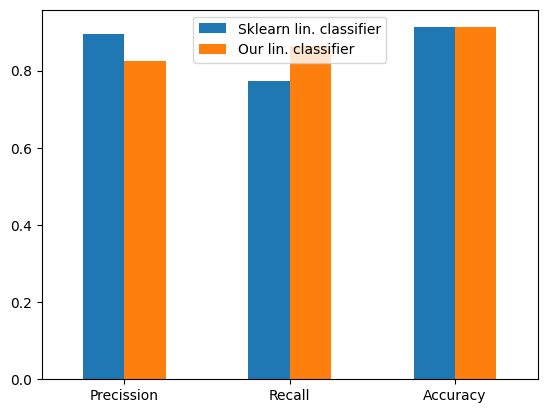

In [184]:
# Testing previous methods

#Linear model
bin_model = LinearDiscriminantAnalysis()    
bin_model.fit(X_train, y_train)
y_pred = bin_model.predict(X_test)
bin_metrics = print_evaluate(y_test, y_pred)

model = LinearClassifier()    
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
m_metrics = print_evaluate(y_test, y_pred)

comparsion = pd.DataFrame({'Sklearn lin. classifier': pd.Series(bin_metrics), 
'Our lin. classifier': pd.Series(m_metrics)})
comparsion.index=pd.Series(['Precission', 'Recall', 'Accuracy'])
print(comparsion)
comparsion.plot.bar(rot=0)

Precision 0.9
Recall 0.8181818181818182
Accuracy 0.925


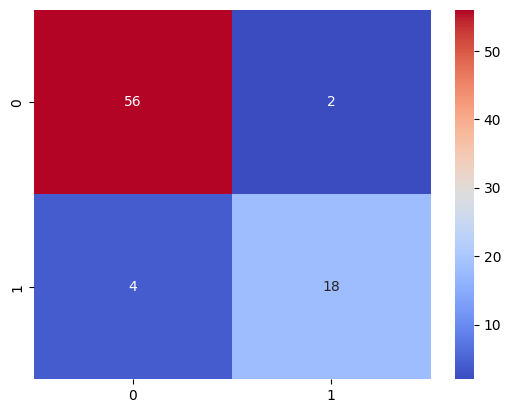

Precision 0.84
Recall 0.9545454545454546
Accuracy 0.9375


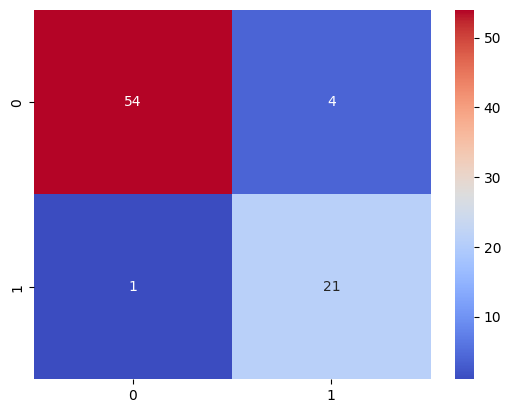

            Sklearn Bayes classifier  Our Bayes classifier
Precission                  0.900000              0.840000
Recall                      0.818182              0.954545
Accuracy                    0.925000              0.937500


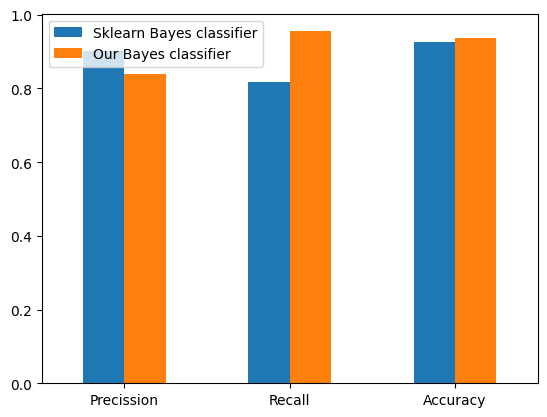

In [185]:
#Bayes model
bin_model = GaussianNB()   
bin_model.fit(X_train, y_train)
y_pred = bin_model.predict(X_test)
bin_metrics = print_evaluate(y_test, y_pred)

model = BayesClassifier()   
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
m_metrics = print_evaluate(y_test, y_pred)

comparsion = pd.DataFrame({'Sklearn Bayes classifier': pd.Series(bin_metrics), 
'Our Bayes classifier': pd.Series(m_metrics)})
comparsion.index=pd.Series(['Precission', 'Recall', 'Accuracy'])
print(comparsion)
comparsion.plot.bar(rot=0)
plt.show()

Precision 0.7142857142857143
Recall 0.6818181818181818
Accuracy 0.8375


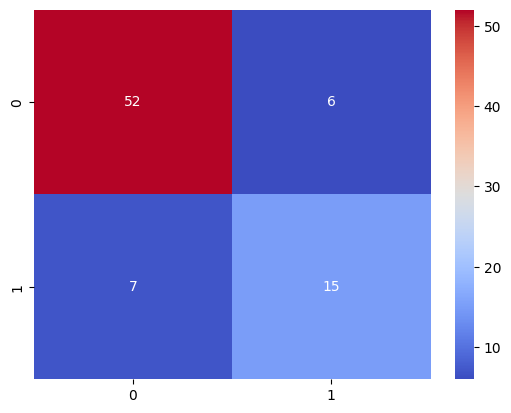

In [187]:
bin_model = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2) 
bin_model.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
bin_metrics = print_evaluate(y_test, y_pred)